In [1]:
import numpy as np

import pandas as pd 
import os

In [2]:
train_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/train"
test_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/test"
val_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/validation"

In [3]:
#processing the data
import tensorflow as tf
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)


In [4]:
#creating datasets
train_data = train_gen.flow_from_directory(train_dir,target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=False)
val_data = test_gen.flow_from_directory(val_dir,target_size=(224,224),class_mode="categorical",batch_size=32,shuffle=False)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


# Transfer Learning using EfficientNetB7

In [5]:
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.5 MB/s eta 0:00:00


In [6]:
# building model for efficientnet7
import tensorflow as tf
import efficientnet.tfkeras as efn

eff_base = efn.EfficientNetB7(weights='imagenet',include_top= False,input_shape=(224,224,3))

for layer in eff_base.layers:
    eff_base.trainable = False

258434480/258434480 [==============================] - 3s 0us/step


In [7]:
#from tensorflow.keras import layers

#inputs = tf.keras.Input(shape=(224,224,3))

x = eff_base.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
outputs = tf.keras.layers.Dense(21, activation="softmax")(x)

eff_model = tf.keras.models.Model(inputs=eff_base.input,outputs=outputs)

In [8]:
# compiling the model

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [9]:
# fitting data to the model

ret_model=eff_model.fit(train_data,
             epochs = 10,
             validation_data = val_data
             )

Epoch 1/10


2023-08-18 19:41:18.184790: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


230/230 [==============================] - 209s 789ms/step - loss: 1.9483 - accuracy: 0.4510 - val_loss: 0.7386 - val_accuracy: 0.7367
Epoch 2/10
230/230 [==============================] - 134s 584ms/step - loss: 0.8531 - accuracy: 0.7229 - val_loss: 0.4733 - val_accuracy: 0.8467
Epoch 3/10
230/230 [==============================] - 135s 588ms/step - loss: 0.6900 - accuracy: 0.7633 - val_loss: 0.4219 - val_accuracy: 0.8538
Epoch 4/10
230/230 [==============================] - 136s 591ms/step - loss: 0.5913 - accuracy: 0.7952 - val_loss: 0.3400 - val_accuracy: 0.8786
Epoch 5/10
230/230 [==============================] - 137s 598ms/step - loss: 0.5007 - accuracy: 0.8291 - val_loss: 0.2598 - val_accuracy: 0.9095
Epoch 6/10
230/230 [==============================] - 137s 597ms/step - loss: 0.4555 - accuracy: 0.8435 - val_loss: 0.2831 - val_accuracy: 0.8986
Epoch 7/10
230/230 [==============================] - 137s 595ms/step - loss: 0.4310 - accuracy: 0.8561 - val_loss: 0.2384 - val_accura

In [10]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 32



In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_dataset = '/kaggle/input/landuse-scene-classification/images_train_test_val/test'
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')
predictions = eff_model.predict(test_generator)
test_loss, test_accuracy = eff_model.evaluate(test_generator, batch_size=BATCH_SIZE)

Found 1050 images belonging to 21 classes.
33/33 [==============================] - 9s 270ms/step - loss: 0.1833 - accuracy: 0.9295


In [12]:
# evaluate the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_data = test_datagen.flow_from_directory('/kaggle/input/landuse-scene-classification/images_train_test_val/test', target_size=(256, 256), batch_size=32, class_mode='categorical',shuffle=True)
loss, acc = eff_model.evaluate(test_data)
print('Test Accuracy: %.3f' % (acc * 100.0))

Found 1050 images belonging to 21 classes.
33/33 [==============================] - 9s 274ms/step - loss: 0.1833 - accuracy: 0.9295
Test Accuracy: 92.952


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  


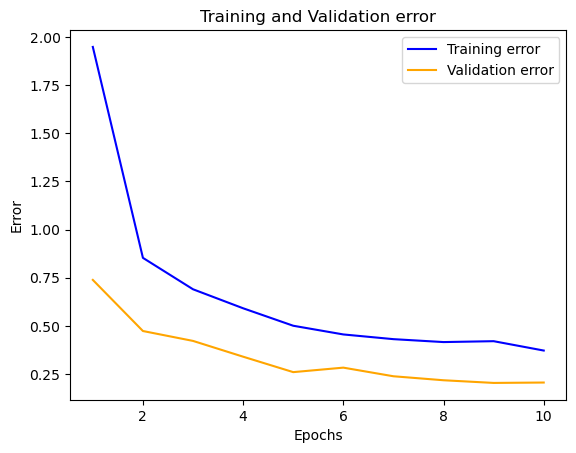

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
history_dict = ret_model.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,'b', label='Training error')
plt.plot(epochs, val_acc,'b', color="orange", label='Validation error')
plt.title('Training and Validation error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

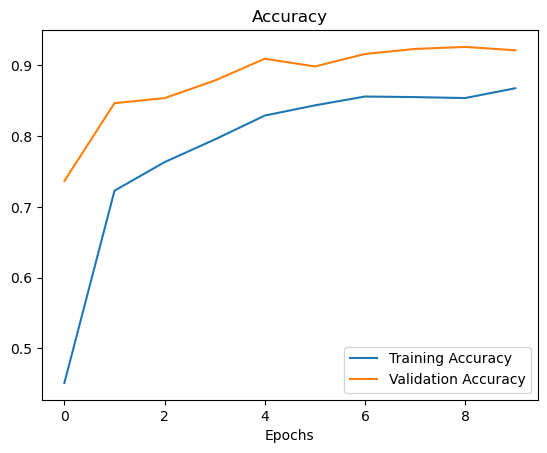

In [14]:
loss = ret_model.history['loss']
val_loss = ret_model.history['val_loss']  
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['loss']))
plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [15]:
import numpy as np
eff_model.evaluate(test_generator)
preds = eff_model.predict(test_generator)
y_preds = np.argmax(preds , axis = 1 )
y_test = np.array(test_generator.labels)

33/33 [==============================] - 9s 262ms/step


In [16]:
from sklearn.metrics import confusion_matrix , classification_report 
import seaborn as sns
class_label=list(train_data.class_indices.keys())

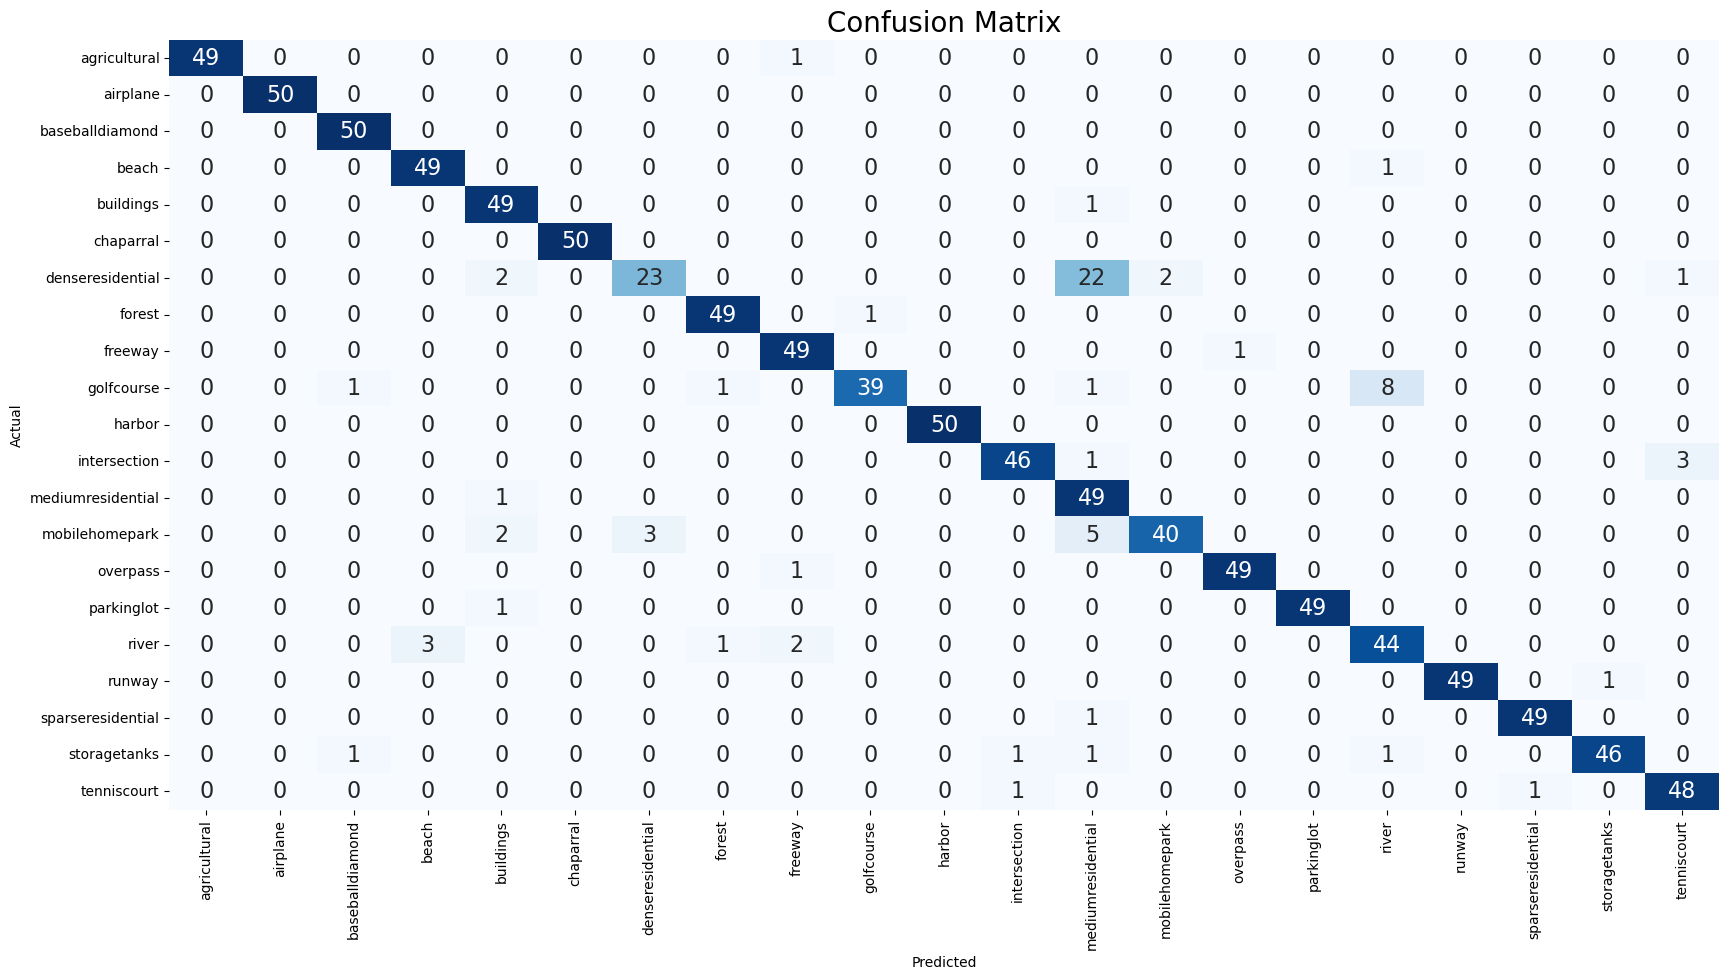

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
cm_data = confusion_matrix(y_test , y_preds)
cm = pd.DataFrame(cm_data, columns=class_label, index = class_label)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (20,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')

In [18]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        50
           2       0.96      1.00      0.98        50
           3       0.94      0.98      0.96        50
           4       0.89      0.98      0.93        50
           5       1.00      1.00      1.00        50
           6       0.88      0.46      0.61        50
           7       0.96      0.98      0.97        50
           8       0.92      0.98      0.95        50
           9       0.97      0.78      0.87        50
          10       1.00      1.00      1.00        50
          11       0.96      0.92      0.94        50
          12       0.60      0.98      0.75        50
          13       0.95      0.80      0.87        50
          14       0.98      0.98      0.98        50
          15       1.00      0.98      0.99        50
          16       0.81      0.88      0.85        50
          17       1.00    